# PAMAP2 DataSet
The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classific  


Link To PAMAP2 dataset - https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring  

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
!unzip PAMAP2_Dataset.zip

--2021-10-09 15:45:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688167640 (656M) [application/x-httpd-php]
Saving to: ‘PAMAP2_Dataset.zip’

PAMAP2_Dataset.zip  100%[===================>] 656.29M  90.9MB/s    in 7.5s    

2021-10-09 15:45:39 (87.8 MB/s) - ‘PAMAP2_Dataset.zip’ saved [688167640/688167640]

Archive:  PAMAP2_Dataset.zip
  inflating: PAMAP2_Dataset/Protocol/subject101.dat  
  inflating: PAMAP2_Dataset/Protocol/subject102.dat  
  inflating: PAMAP2_Dataset/Protocol/subject103.dat  
  inflating: PAMAP2_Dataset/Protocol/subject104.dat  
  inflating: PAMAP2_Dataset/Protocol/subject105.dat  
  inflating: PAMAP2_Dataset/Protocol/subject106.dat  
  inflating: PAMAP2_Dataset/Protocol/subject107.dat  
  inflating: PAMAP2_Dataset/P

## Imports Liberaries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Dropout

In [ ]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [ ]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='/content/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [ ]:
data.head(5)

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,hand_3D_magnetometer_z,hand_4D_orientation_x,hand_4D_orientation_y,hand_4D_orientation_z,hand_4D_orientation_w,chest_temperature,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,chest_3D_acceleration_6_x,chest_3D_acceleration_6_y,chest_3D_acceleration_6_z,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_4D_orientation_z,chest_4D_orientation_w,ankle_temperature,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.0,0.0,0.0,0.0,31.8125,0.238080,9.80003,-1.68896,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.0,0.0,0.0,0.0,30.3125,9.65918,-1.65569,-0.099797,9.64689,-1.55576,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047758,0.006474,14.8991,-69.2224,-5.82311,1.0,0.0,0.0,0.0,31.8125,0.319530,9.61282,-1.49328,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.0,0.0,0.0,0.0,30.3125,9.69370,-1.57902,-0.215687,9.61670,-1.61630,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.0,0.0,0.0,0.0,31.8125,0.235593,9.72421,-1.76621,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.0,0.0,0.0,0.0,30.3125,9.58944,-1.73276,0.092914,9.63173,-1.58605,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.0,0.0,0.0,0.0,31.8125,0.388697,9.53572,-1.72410,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.0,0.0,0.0,0.0,30.3125,9.58814,-1.77040,0.054545,9.63197,-1.63135,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.0,0.0,0.0,0.0,31.8125,0.315800,9.49908,-1.60914,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.0,0.0,0.0,0.0,30.3125,9.69771,-1.65625,-0.060809,9.64699,-1.64647,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


* As we can see we have NaN in our data, so we need to change their value. We will take every NaN value and eplace it with the mean value of the column.
* Also, we can note from the map that acitvity_id = 0 is not an valid activity

In [ ]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

# 1) a. Exploratory DataSet from Documentation:



Activity analysis for all the subjects 

In [ ]:
data.describe()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,hand_3D_magnetometer_z,hand_4D_orientation_x,hand_4D_orientation_y,hand_4D_orientation_z,hand_4D_orientation_w,chest_temperature,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,chest_3D_acceleration_6_x,chest_3D_acceleration_6_y,chest_3D_acceleration_6_z,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_4D_orientation_z,chest_4D_orientation_w,ankle_temperature,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,1.480977e-03,3.974584e-02,-3.182852e-03,2.114699e+01,-1.396831e+01,-2.437034e+01,5.658328e-01,-4.135042e-02,-1.213226e-01,-4.817431e-02,3.617908e+01,3.333707e-01,8.152683e+00,-1.450553e+00,1.993197e-01,8.148290e+00,-1.121257e+00,5.575033e-03,1.174622e-02,-2.290167e-02,4.470582e+00,-3.065308e+01,4.585338e+00,5.346176e-01,-3.954376e-01,8.782836e-02,8.694449e-02,3.371194e+01,9.408387e+00,-1.531939e-01,-2.592432e+00,9.378478e+00,-4.550154e-02,-2.174212e+00,9.960309e-03,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,1.045664e+02
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,1.332331e+00,9.562312e-01,1.598818e+00,2.380841e+01,2.423180e+01,2.007772e+01,3.086261e-01,3.631710e-01,3.333906e-01,5.681133e-01,1.495082e+00,1.742569e+00,4.889461e+00,4.762784e+00,1.738353e+00,4.849979e+00,4.770992e+00,4.498953e-01,5.644552e-01,3.173265e-01,1.704069e+01,1.753230e+01,2.159140e+01,3.007659e-01,3.009480e-01,4.746242e-01,3.691103e-01,1.092343e+00,6.528143e+00,7.739433e+00,3.936154e+00,6.067634e+00,7.190996e+00,3.475429e+00,1.126903e+00,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,-2.813540e+01,-1.784950e+01,-1.426470e+01,-1.039410e+02,-2.000430e+02,-1.649370e+02,1.364250e-07,-9.989440e-01,-9.749160e-01,-9.993260e-01,3.193750e+01,-3.920340e+01,-4.692460e+01,-8.016680e+01,-3.420400e+01,-4.825720e+01,-6.180410e+01,-1.252510e+01,-5.068580e+00,-4.404200e+00,-7.006270e+01,-1.224800e+02,-6.668470e+01,7.710670e-08,-9.994670e-01,-9.996350e-01,-8.801950e-01,3.000000e+01,-1.550680e+02,-1.574430e+02,-1.589260e+02,-6.114200e+01,-6

# Element Analysis 

In [ ]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of uniqe activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  9
Numbe of uniqe activitys in the data:  12


# 1) b. Balance Analysis
check for each subject if there equal number of sampels

In [ ]:
def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd[column_a], color=plt.cm.Paired(size))
    a = ax.set_xticklabels(pd[column_b])
    b = ax.legend(fontsize = 20)
    c = ax.set_xticks(np.arange(len(pd)))
    d = ax.set_title(title)
    plt.show()
    

No handles with labels found to put in legend.


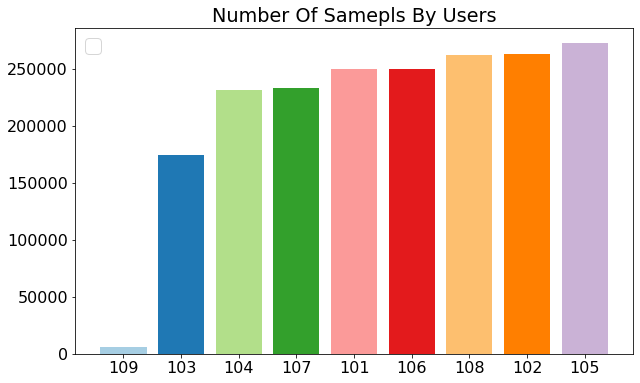

In [ ]:
sampels = data.groupby(['id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['id'] = sampels['id']
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','id','Number Of Samepls By Users')

No handles with labels found to put in legend.


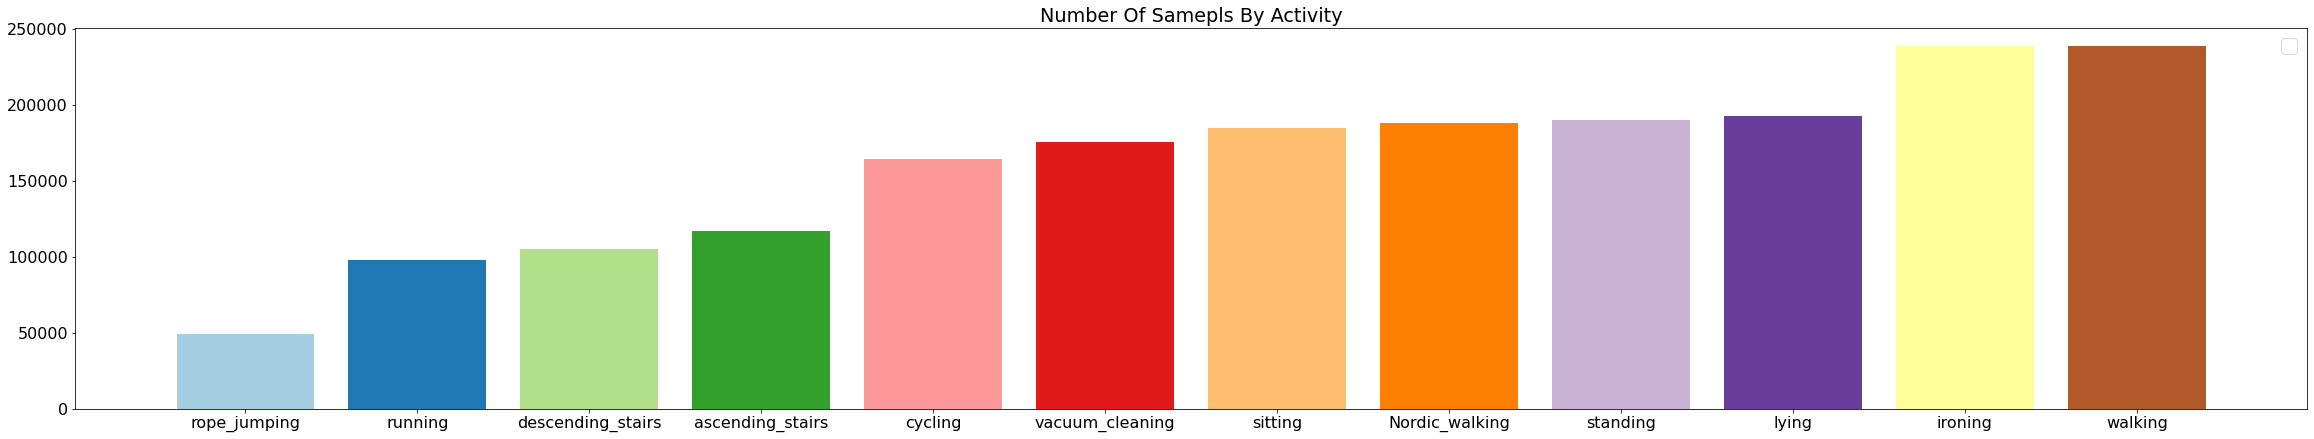

In [ ]:
map_ac = load_activity_map()
sampels = data.groupby(['activity_id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['activity'] = [map_ac[x] for x in sampels['activity_id']]
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','activity','Number Of Samepls By Activity',figsize=(40,7))

We can see the data isn't balenced:
* Subject 109 as less sampels then all others subjects.
* rope_jumping activity as less sampels then other activities 

## Tempature Analysis

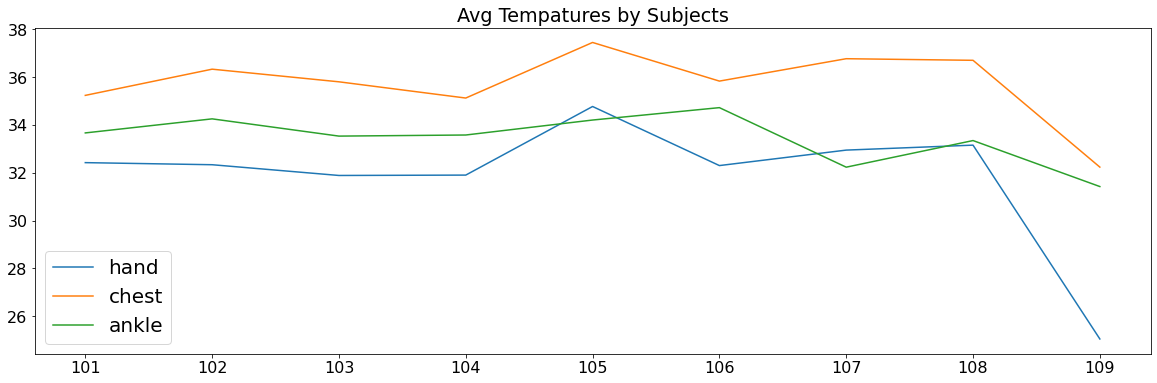

In [ ]:
samepls_tempreture = pd.DataFrame()
samepls_tempreture['hand'] = result_id['hand_temperature']
samepls_tempreture['chest'] = result_id['chest_temperature']
samepls_tempreture['ankle'] = result_id['ankle_temperature']

ax = samepls_tempreture.plot(kind='line', figsize=(20,6), title='Avg Tempatures by Subjects')
a = ax.set_xticklabels(result_id['id'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls_tempreture)))

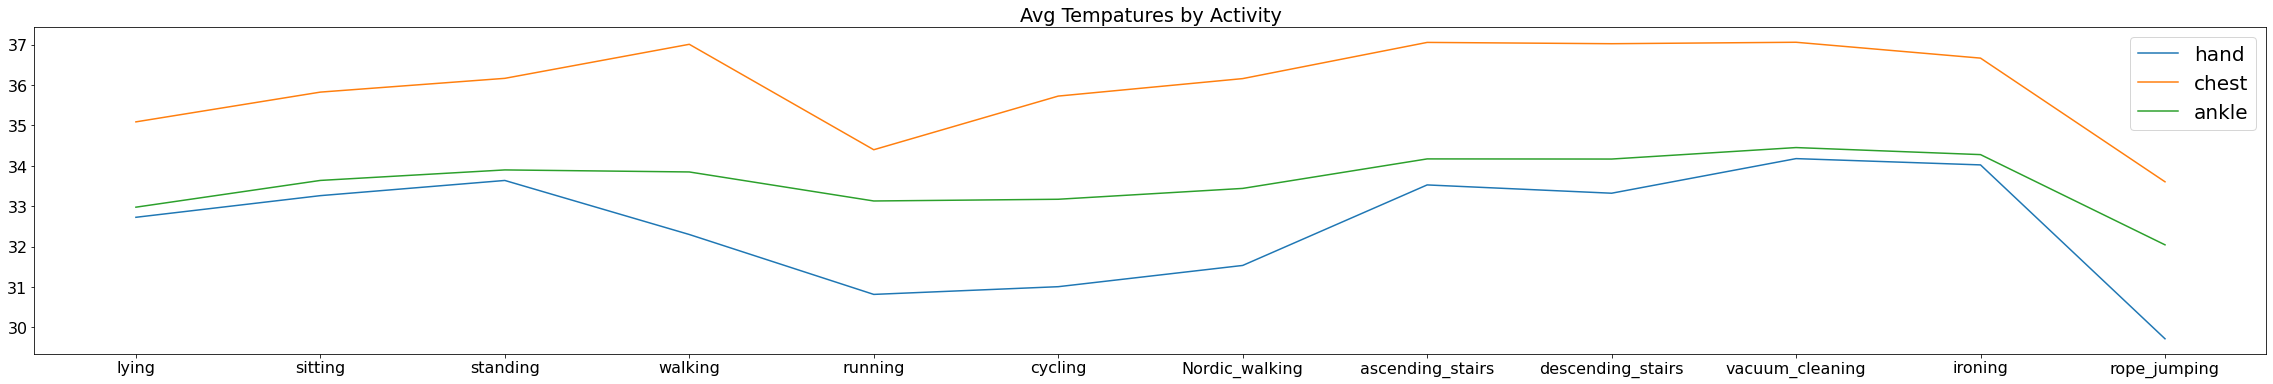

In [ ]:
map_ac = load_activity_map()
samepls_tempreture = pd.DataFrame()
samepls_tempreture['activity'] = [map_ac[x] for x in result_act['activity_id']]
samepls_tempreture['hand'] = result_act['hand_temperature']
samepls_tempreture['chest'] = result_act['chest_temperature']
samepls_tempreture['ankle'] = result_act['ankle_temperature']

ax = samepls_tempreture.plot(kind='line', figsize=(40,6), title='Avg Tempatures by Activity')
a = ax.set_xticklabels(samepls_tempreture['activity'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls_tempreture)))

we can see that suject 109 as the lowest tempetures in all the parts of the humen body that were measured, And the lowest activity temptures is rope_jumping

## Sensor Analysis

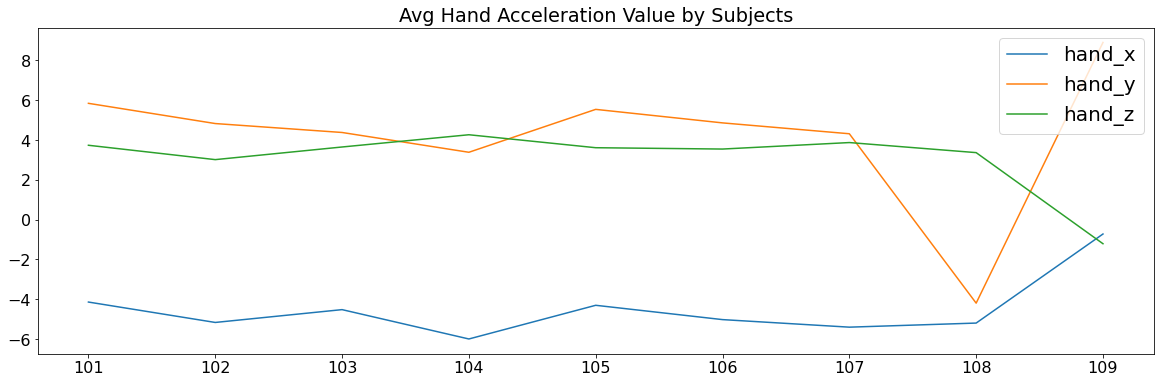

In [ ]:
samepls = pd.DataFrame()
samepls['hand_x'] = result_id['hand_3D_acceleration_16_x']
samepls['hand_y'] = result_id['hand_3D_acceleration_16_y']
samepls['hand_z'] = result_id['hand_3D_acceleration_16_z']
ax = samepls.plot(kind='line', figsize=(20,6), title='Avg Hand Acceleration Value by Subjects')
a = ax.set_xticklabels(result_id['id'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls)))

we can see that almost all the subjects hand sensor are acting the same however there is somthing strang in subject 108 y value of his hand sensor?

# Finally, I will save the modified Data Set after Wrampling it
i will save the data into drive, for the next steps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.to_csv('data.csv')
!cp data.csv "/content/drive/MyDrive"